"""
# Runway Line Detection System
Automatic detection of runway lines using hybrid thresholding and edge detection with statistical analysis
"""

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from IPython.display import display, clear_output
import ipywidgets as widgets


In [ ]:
class RunwayDetector:
    def __init__(self, video_path):
        self.video_path = video_path
        self.cap = cv2.VideoCapture(str(video_path))
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.sample_frames = self._get_sample_frames(10)
        self._determine_thresholds()
        
    def _get_sample_frames(self, n):
        """Capture sample frames from video"""
        samples = []
        for i in range(n):
            pos = int(i * (self.frame_count-1) / n)
            self.cap.set(cv2.CAP_PROP_POS_FRAMES, pos)
            ret, frame = self.cap.read()
            if ret:
                samples.append(frame)
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        return samples
    
    def _determine_thresholds(self):
        """Automatically determine optimal thresholds"""
        # Otsu's threshold for white/black lines
        gray_samples = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in self.sample_frames]
        self.white_thresh = np.median([cv2.threshold(g, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[0] 
                            for g in gray_samples])
        self.black_thresh = np.median([cv2.threshold(g, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[0] 
                            for g in gray_samples])
        
        # Canny edge thresholds
        edge_mags = []
        for g in gray_samples:
            dx = cv2.Sobel(g, cv2.CV_64F, 1, 0)
            dy = cv2.Sobel(g, cv2.CV_64F, 0, 1)
            edge_mags.extend(np.sqrt(dx**2 + dy**2).flatten())
        self.canny_low = np.percentile(edge_mags, 25)
        self.canny_high = np.percentile(edge_mags, 75)
        
    def process_frame(self, frame):
        """Process a single frame through pipeline"""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Stage 1: Thresholding
        _, white_mask = cv2.threshold(gray, self.white_thresh, 255, cv2.THRESH_BINARY)
        _, black_mask = cv2.threshold(gray, self.black_thresh, 255, cv2.THRESH_BINARY_INV)
        
        # Stage 2: Edge Detection
        edges = cv2.Canny(gray, self.canny_low, self.canny_high)
        
        # Stage 3: Mask Combination
        combined = cv2.bitwise_or(
            cv2.bitwise_and(white_mask, edges),
            cv2.bitwise_and(black_mask, edges)
        )
        
        # Stage 4: Contour Detection
        contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Stage 5: Contour Filtering
        valid_contours = []
        contour_props = []
        for cnt in contours:
            props = self._analyze_contour(cnt)
            if props['valid']:
                valid_contours.append(cnt)
                contour_props.append(props)
        
        return {
            'original': frame,
            'white_mask': white_mask,
            'black_mask': black_mask,
            'edges': edges,
            'combined': combined,
            'contours': valid_contours,
            'contour_props': contour_props,
            'result': self._draw_results(frame.copy(), valid_contours)
        }
    
    def _analyze_contour(self, cnt):
        """Calculate contour properties and validate"""
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        x,y,w,h = cv2.boundingRect(cnt)
        
        props = {
            'area': area,
            'perimeter': perimeter,
            'width': w,
            'height': h,
            'aspect_ratio': w/max(h, 1e-5),
            'circularity': (4 * np.pi * area) / max(perimeter**2, 1e-5),
            'solidity': area / max(w*h, 1e-5),
            'valid': False
        }
        
        # Validation criteria
        props['valid'] = (
            500 < area < 10000 and
            0.1 < props['circularity'] < 0.5 and
            props['aspect_ratio'] > 4 and
            props['solidity'] > 0.4
        )
        return props
    
    def _draw_results(self, frame, contours):
        """Draw detected contours on frame"""
        for cnt in contours:
            cv2.drawContours(frame, [cnt], -1, (0,255,0), 2)
            x,y,w,h = cv2.boundingRect(cnt)
            cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 1)
        return frame


In [ ]:
# Initialize detector with sample video
video_path = "data/input videos/video_2.avi"
detector = RunwayDetector(video_path)

# Display automatically determined thresholds
print(f"Auto-detected thresholds:")
print(f"White line threshold: {detector.white_thresh}")
print(f"Black line threshold: {detector.black_thresh}")
print(f"Canny thresholds: {detector.canny_low}, {detector.canny_high}")

Auto-detected thresholds:
White line threshold: 154.0
Black line threshold: 154.0
Canny thresholds: 4.47213595499958, 17.029386365926403


In [ ]:
# Process and visualize a sample frame
sample_frame = detector.sample_frames[0]
results = detector.process_frame(sample_frame)

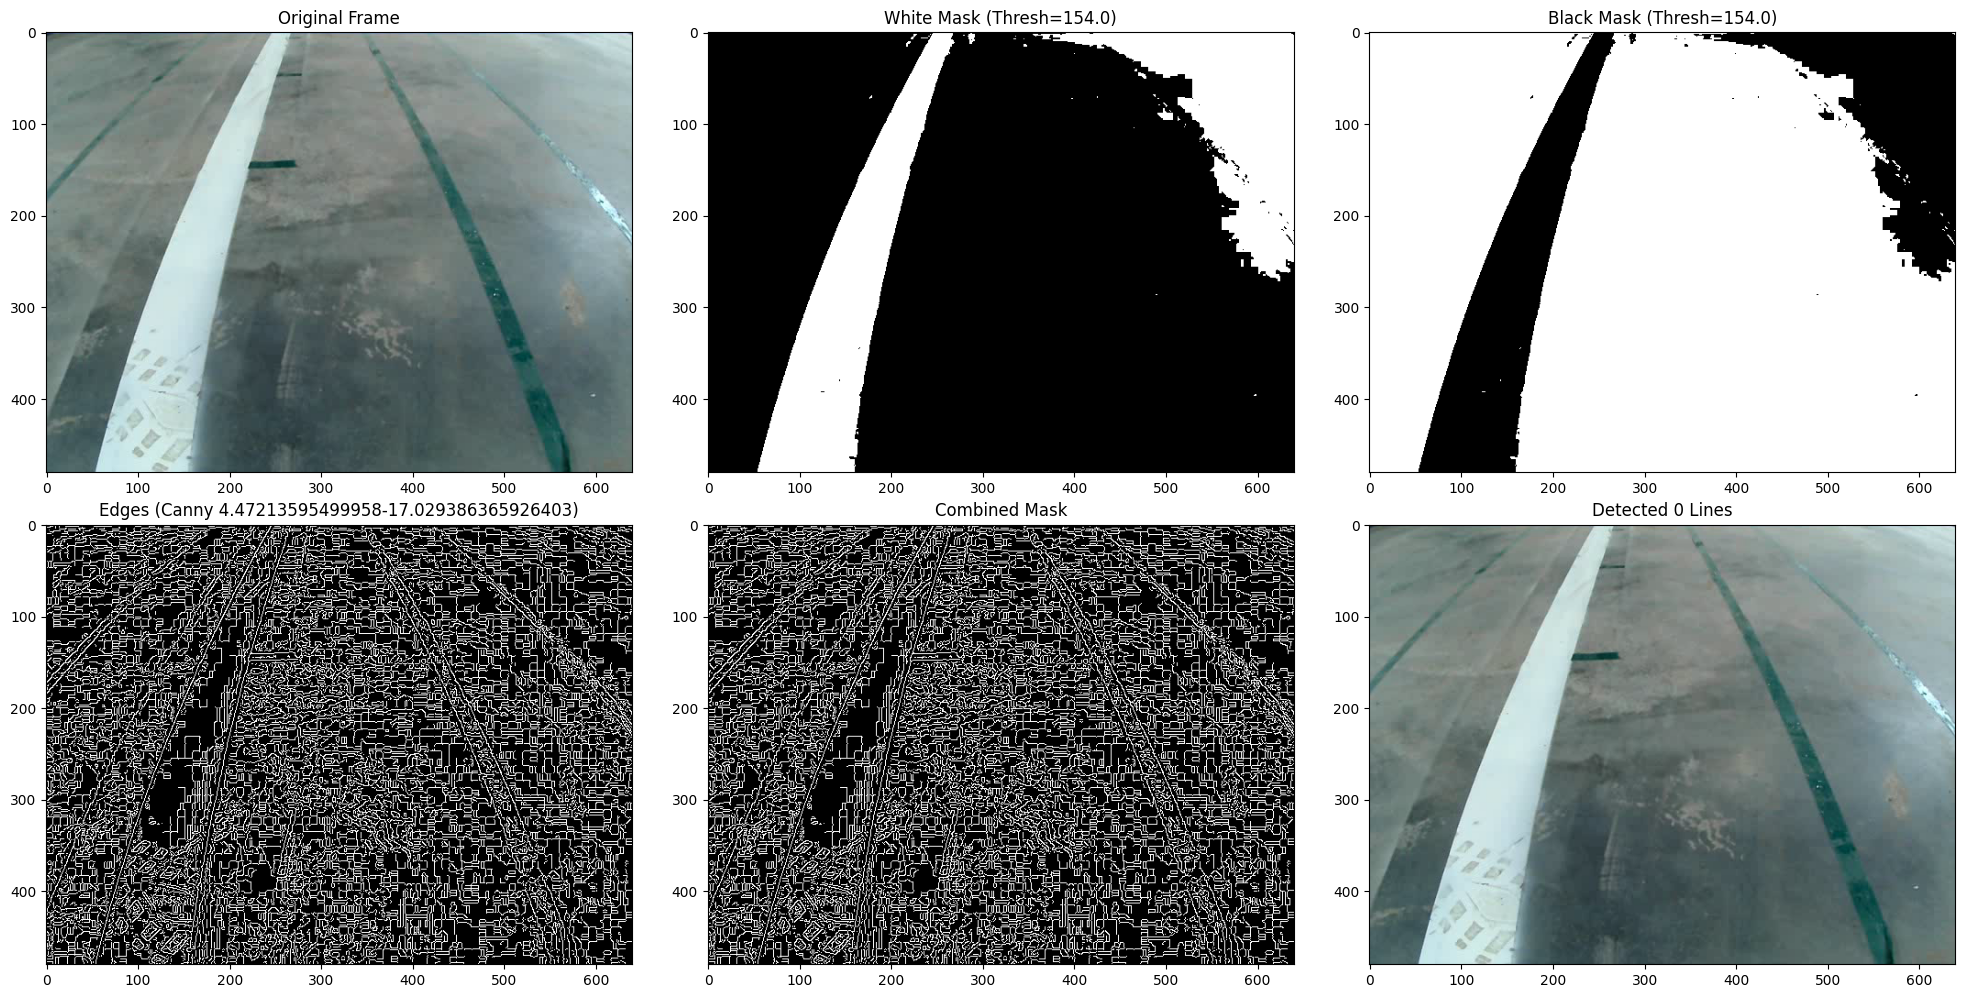

In [ ]:
# Display processing pipeline
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
plt.title("Original Frame")

plt.subplot(2, 3, 2)
plt.imshow(results['white_mask'], cmap='gray')
plt.title(f"White Mask (Thresh={detector.white_thresh})")

plt.subplot(2, 3, 3)
plt.imshow(results['black_mask'], cmap='gray')
plt.title(f"Black Mask (Thresh={detector.black_thresh})")

plt.subplot(2, 3, 4)
plt.imshow(results['edges'], cmap='gray')
plt.title(f"Edges (Canny {detector.canny_low}-{detector.canny_high})")

plt.subplot(2, 3, 5)
plt.imshow(results['combined'], cmap='gray')
plt.title("Combined Mask")

plt.subplot(2, 3, 6)
plt.imshow(cv2.cvtColor(results['result'], cv2.COLOR_BGR2RGB))
plt.title(f"Detected {len(results['contours'])} Lines")

plt.tight_layout()
plt.show()

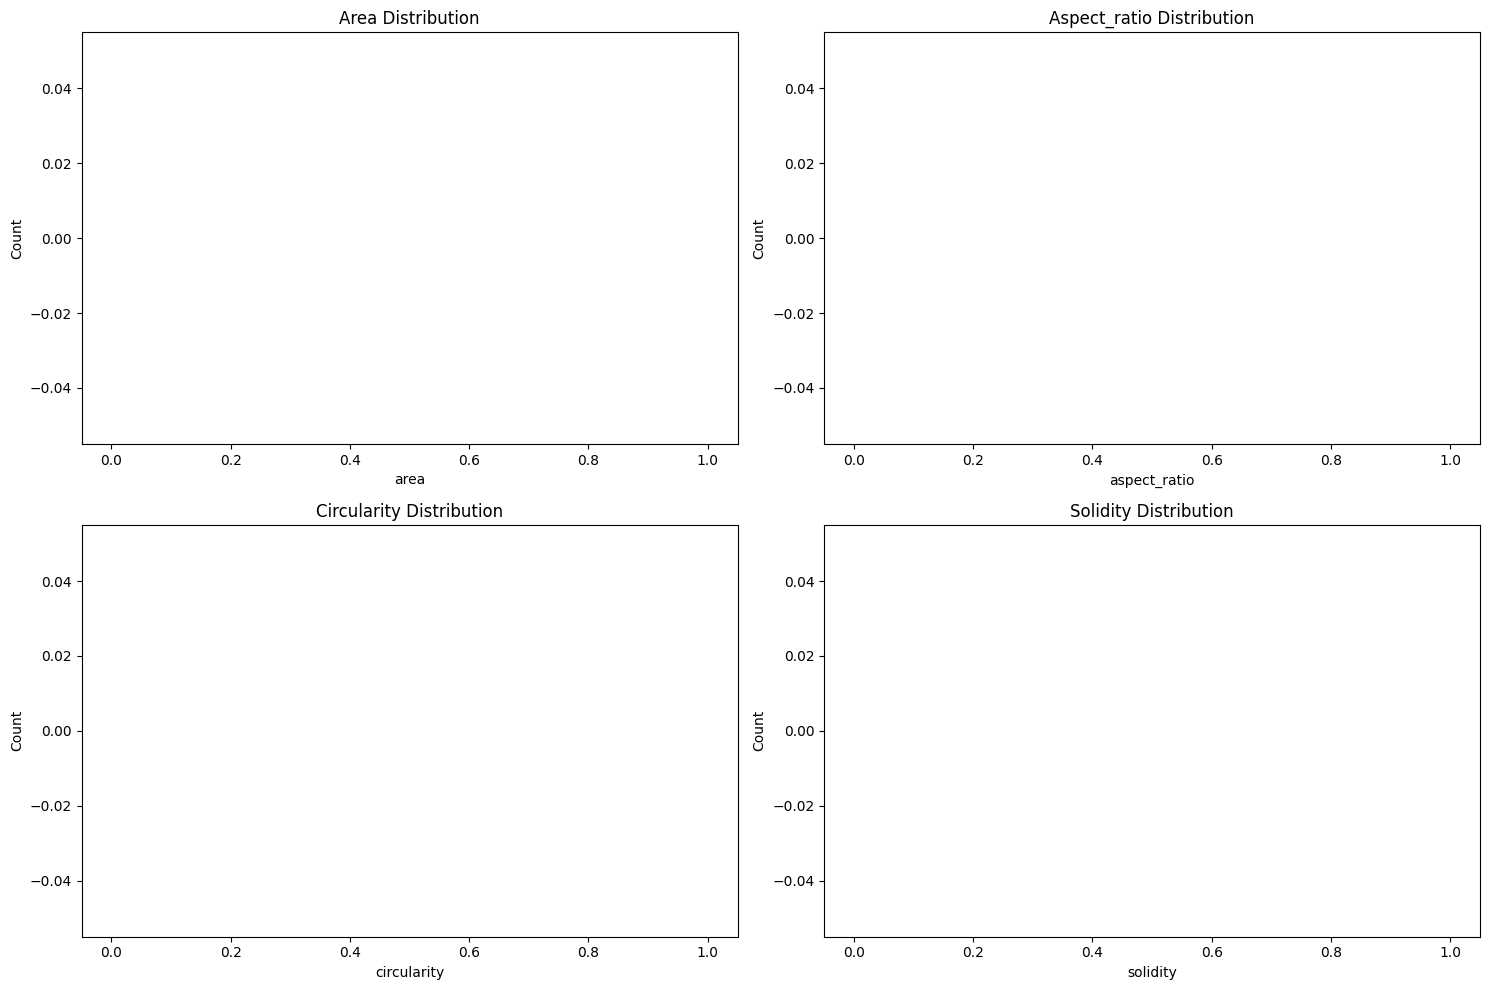

In [ ]:
# Contour Properties Analysis
contour_props = results['contour_props']

# Create property histograms
plt.figure(figsize=(15, 10))

properties = ['area', 'aspect_ratio', 'circularity', 'solidity']
for i, prop in enumerate(properties):
    plt.subplot(2, 2, i+1)
    plt.hist([p[prop] for p in contour_props], bins=10)
    plt.title(f"{prop.capitalize()} Distribution")
    plt.xlabel(prop)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

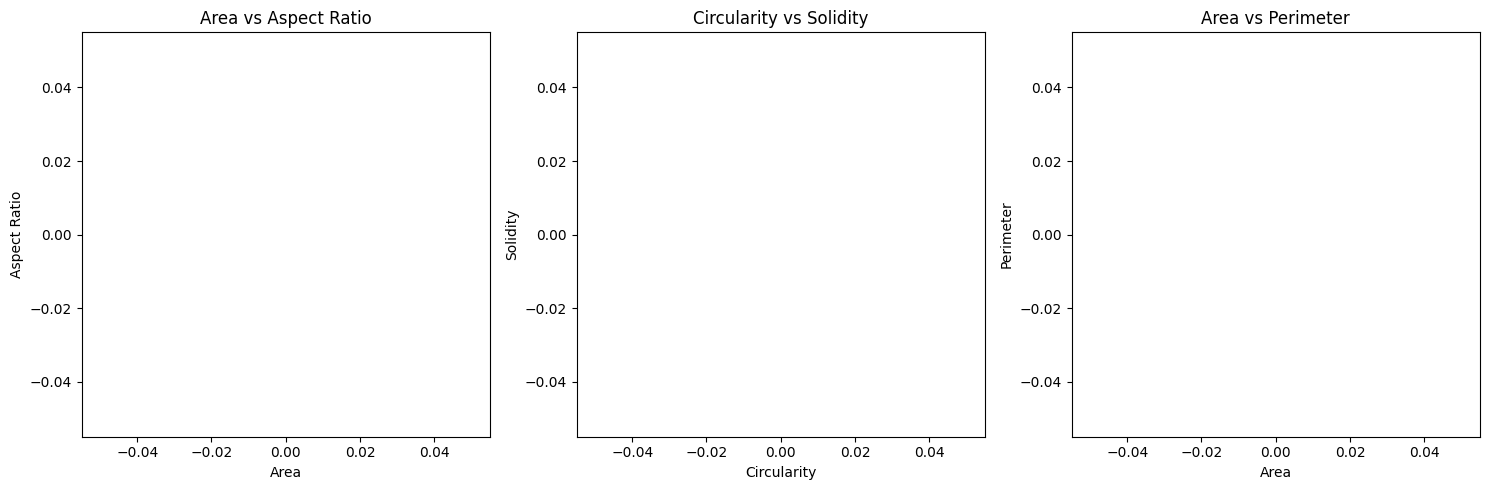

In [ ]:
# Property Scatter Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter([p['area'] for p in contour_props], [p['aspect_ratio'] for p in contour_props])
plt.xlabel('Area')
plt.ylabel('Aspect Ratio')
plt.title('Area vs Aspect Ratio')

plt.subplot(1, 3, 2)
plt.scatter([p['circularity'] for p in contour_props], [p['solidity'] for p in contour_props])
plt.xlabel('Circularity')
plt.ylabel('Solidity')
plt.title('Circularity vs Solidity')

plt.subplot(1, 3, 3)
plt.scatter([p['area'] for p in contour_props], [p['perimeter'] for p in contour_props])
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.title('Area vs Perimeter')

plt.tight_layout()
plt.show()


In [ ]:
# Batch Process and Save Results
output_dir = Path("data/experimental_results/notebook_output")
output_dir.mkdir(exist_ok=True, parents=True)

contour_data = []
for frame_idx in range(detector.frame_count):
    detector.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = detector.cap.read()
    if not ret:
        break
    
    results = detector.process_frame(frame)
    cv2.imwrite(str(output_dir/f"frame_{frame_idx:04d}.png"), results['result'])
    
    # Save contour data for analysis
    for props in results['contour_props']:
        contour_data.append({
            'frame': frame_idx,
            **props
        })
    
    if frame_idx % 50 == 0:
        print(f"Processed frame {frame_idx}/{detector.frame_count}")

detector.cap.release()

In [ ]:
# Final Analysis of All Contours
import pandas as pd
df = pd.DataFrame(contour_data)

print("\nSummary Statistics:")
print(df.describe())

# Plot temporal distribution
plt.figure(figsize=(12, 4))
plt.plot(df.groupby('frame').size(), 'b-')
plt.xlabel("Frame Number")
plt.ylabel("Lines Detected")
plt.title("Line Detection Over Time")
plt.grid(True)
plt.show()

In [ ]:
# 3D Visualization of Contour Properties
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['area'], df['aspect_ratio'], df['circularity'], c=df['solidity'], cmap='viridis')
ax.set_xlabel('Area')
ax.set_ylabel('Aspect Ratio')
ax.set_zlabel('Circularity')
ax.set_title('3D Contour Property Space')
plt.show()